In [ ]:
from google.colab import drive4
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split

change batch size

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [3]:
data_dir  = '/content/drive/MyDrive/Final year Project/data'

classes = os.listdir(data_dir)
print(classes)

['plastic', 'metal', 'cardboard', 'glass', 'trash', 'paper', 'ps', 'pp', 'pet', 'pe-hd']


In [4]:
len(classes)

10

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [ ]:
def show_img(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  pe-hd (4)


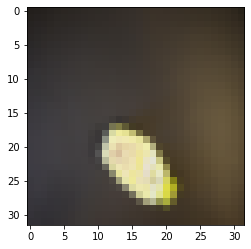

In [ ]:
img, label = dataset[2222]
show_img(img, label)

In [6]:
random_seed = 42
torch.manual_seed(random_seed);

In [7]:
len(dataset)

6487

68% train, 12% val, 20% test

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [4736, 778, 973])
len(train_ds), len(val_ds), len(test_ds)

(4736, 778, 973)

In [ ]:
batch_size=128

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

NameError: ignored

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(24, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

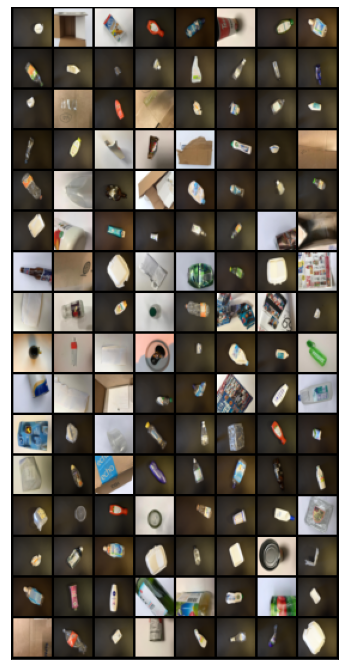

In [ ]:
show_batch(train_dl)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
W = 256
K = 4
S = 2
P = 1

In [ ]:
(((W - K + 2*P)/S) + 1)

128.0

In [14]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0196, -0.0190,  0.0210, -0.0541, -0.0291,  0.0236,  0.0235, -0.0225,
         0.0325, -0.0240], grad_fn=<SelectBackward0>)


In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.295245885848999, 'val_acc': 0.0576171875}

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.9599, val_loss: 0.7445, val_acc: 0.7348
Epoch [1], train_loss: 0.8099, val_loss: 0.7018, val_acc: 0.7396
Epoch [2], train_loss: 0.7591, val_loss: 0.6401, val_acc: 0.7773
Epoch [3], train_loss: 0.7001, val_loss: 0.7019, val_acc: 0.7465
Epoch [4], train_loss: 0.6600, val_loss: 0.6731, val_acc: 0.7670
Epoch [5], train_loss: 0.6247, val_loss: 0.6816, val_acc: 0.7371
Epoch [6], train_loss: 0.5562, val_loss: 0.6087, val_acc: 0.7969
Epoch [7], train_loss: 0.5414, val_loss: 0.5753, val_acc: 0.8037
Epoch [8], train_loss: 0.4736, val_loss: 0.5565, val_acc: 0.8145
Epoch [9], train_loss: 0.4818, val_loss: 0.5870, val_acc: 0.7930
Epoch [10], train_loss: 0.4519, val_loss: 0.5192, val_acc: 0.8350
Epoch [11], train_loss: 0.3798, val_loss: 0.5399, val_acc: 0.8158
Epoch [12], train_loss: 0.4022, val_loss: 0.8156, val_acc: 0.7611
Epoch [13], train_loss: 0.3716, val_loss: 0.4932, val_acc: 0.8457
Epoch [14], train_loss: 0.2925, val_loss: 0.5372, val_acc: 0.8369
Epoch [15], train_lo

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

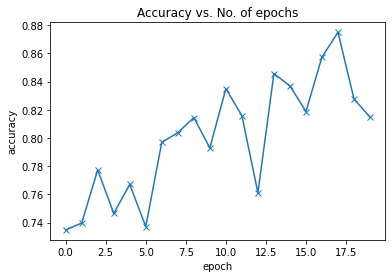

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

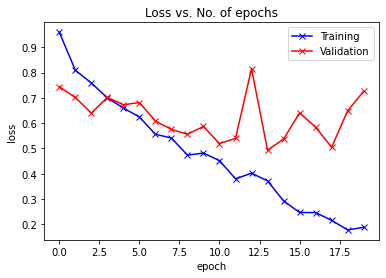

In [ ]:
plot_losses(history)

In [ ]:
model_path = "/content/drive/MyDrive/Final year Project/model_state_custom_dataset.pt"

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
torch.save(model, "/content/drive/MyDrive/Final year Project/full_model_custom_full_dataset.pt")

In [15]:
the_model_sdf = torch.load("/content/drive/MyDrive/Final year Project/full_model_custom_full_dataset.pt")

In [16]:
len(val_ds)

778

In [17]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [21]:
corrrect_pred_count = 0

for i in range(778):
  img, label = val_ds[i]
  predicted_label = predict_image(img, the_model_sdf)
  true_label = dataset.classes[label]
  if predicted_label == true_label:
    corrrect_pred_count +=1
  

val_accuracy = float(corrrect_pred_count)/float(778)*100

val_accuracy

78.7917737789203

In [23]:
corrrect_pred_count = 0

for i in range(973):
  img, label = test_ds[i]
  predicted_label = predict_image(img, the_model_sdf)
  true_label = dataset.classes[label]
  if predicted_label == true_label:
    corrrect_pred_count +=1
  

test_accuracy = float(corrrect_pred_count)/float(973)*100

test_accuracy

79.13669064748201